In [37]:
pip install tensorflow


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [11]:
import tensorflow as tf
import os
import time

# Clear session
tf.keras.backend.clear_session()

# Define the BinaryFocalLoss class
class BinaryFocalLoss(tf.keras.losses.Loss):
    def __init__(self, gamma=2.0, alpha=0.25, **kwargs):
        super().__init__(**kwargs)
        self.gamma = gamma
        self.alpha = alpha

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        p_t = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        alpha_factor = tf.where(tf.equal(y_true, 1), self.alpha, 1 - self.alpha)
        modulating_factor = tf.pow(1.0 - p_t, self.gamma)
        cross_entropy = -tf.math.log(p_t)
        loss = alpha_factor * modulating_factor * cross_entropy
        return tf.reduce_mean(loss)

print("Loading model...")
start_time = time.time()

# Load model with compile=False
model = tf.keras.models.load_model('best_model.h5', 
                                 custom_objects={'BinaryFocalLoss': BinaryFocalLoss},
                                 compile=False)

# Recompile the model
model.compile(
    optimizer='adam',
    loss=BinaryFocalLoss(gamma=2.0, alpha=0.25),
    metrics=['accuracy']
)

print(f"Model loaded in {time.time() - start_time:.2f} seconds")

# Convert to TFLite with basic settings
print("\nStarting conversion...")
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Basic conversion settings
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
converter.optimizations = []  # No optimizations for basic conversion

try:
    print("Converting... (this might take several minutes)")
    print("Please wait, the process is running...")
    tflite_model = converter.convert()
    
    print("\nSaving model...")
    with open('model_basic.tflite', 'wb') as f:
        f.write(tflite_model)
    
    size_mb = os.path.getsize('model_basic.tflite') / (1024 * 1024)
    print(f"Model saved. Size: {size_mb:.2f} MB")
    print("Conversion completed successfully!")
    
except Exception as e:
    print(f"Error during conversion: {str(e)}")

print("\nProcess finished!")

Loading model...


AttributeError: 'str' object has no attribute 'quantization_mode'

In [ ]:
from sklearn.utils import class_weight
import numpy as np

try:
    print("Starting label extraction...")
    train_labels = []
    
    # Process only a subset of the dataset
    max_samples = 1000
    sample_count = 0
    
    # Disable shuffling temporarily for consistent sampling
    for images, labels in train_ds.unbatch().take(max_samples):
        label_value = labels.numpy().item()  # Convert to Python scalar
        train_labels.append(label_value)
        sample_count += 1
        
        if sample_count >= max_samples:
            break
            
    train_labels = np.array(train_labels)
    
    # Get class distribution
    unique, counts = np.unique(train_labels, return_counts=True)
    print("\nClass distribution:")
    for class_id, count in zip(unique, counts):
        print(f"Class {int(class_id)}: {count} samples")
    
    # Compute class weights with explicit type conversion
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )
    
    # Convert to dictionary with integer keys
    class_weights = {int(i): float(weight) for i, weight in enumerate(class_weights)}
    print("\nComputed class weights:", class_weights)

except Exception as e:
    print(f"Error during computation: {str(e)}")
    # Fallback weights - give more weight to minority class
    class_weights = {0: 7.0, 1: 1.0}  # Adjusted based on class distribution
    print("Using fallback class weights:", class_weights)

# Print final confirmation
print("\nFinal class weights to be used:", class_weights)

Starting label extraction...

Class distribution:
Class 0: 60 samples
Class 1: 940 samples

Computed class weights: {0: 8.333333333333334, 1: 0.5319148936170213}

Final class weights to be used: {0: 8.333333333333334, 1: 0.5319148936170213}


2024-11-01 10:44:57.395381: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [36]:
pip install tensorflow
pip install scikit-learn

SyntaxError: invalid syntax (4073837367.py, line 1)

In [39]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

# Define paths
test_dir = '/Users/arianmoeini/Desktop/hardware/esp-idf/examples/arian/esp-eye-image-classification/trainingModel/dataset/test'
train_dir = '/Users/arianmoeini/Desktop/hardware/esp-idf/examples/arian/esp-eye-image-classification/trainingModel/dataset/train'

# Parameters
batch_size = 8
img_height = 224
img_width = 224
seed = 123

# Load training data
train_ds = image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=seed
)

# Load test data
test_ds = image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=False
)

Found 76454 files belonging to 2 classes.
Found 20696 files belonging to 2 classes.


In [40]:
import tensorflow.keras.backend as K
from tensorflow.keras import layers

def preprocess_image(image, label):
    # Example: Cropping the central 224x224 region
    image = tf.image.resize_with_crop_or_pad(image, img_height, img_width)
    
    # Enhance contrast
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    return image, label

train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

In [41]:
# Add this before the class weight computation
AUTOTUNE = tf.data.AUTOTUNE

# Optimize the data pipeline
train_ds = train_ds.unbatch()
train_ds = train_ds.cache()  # Cache after take
train_ds = train_ds.shuffle(buffer_size=100)  # Smaller shuffle buffer
train_ds = train_ds.batch(8)  # Rebatch
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

In [4]:
pip install scikit-learn

  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/49/21/3723de321531c9745e40f1badafd821e029d346155b6c79704e0b7197552/scikit_learn-1.5.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for scipy>=1.6.0 from https://files.pythonhosted.org/packages/93/6b/701776d4bd6bdd9b629c387b5140f006185bd8ddea16788a44434376b98f/scipy-1.14.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 6.6 MB/s eta 0:00:00
  Obtaining dependency information for joblib>=1.2.0 from https://files.pythonhosted.org/packages/91/29/df4b9b42f2be0b623cbd5e2140cafcaa2bef0759a00b7b70104dcfe2fb51/joblib-1.4.2-py3-none-any.whl.metadata
  Obtaining dependency information for threadpoolctl>=3.1.0 from https://files.pythonhosted.org/packages/4b/2c/ffbf7a134b9ab11a67b0cf0726453cedd9c5043a4fe7a35d1cefa9a1bcfb/threadpoolctl-3.5.0-py3-none-any.whl.metadata
  

In [42]:
from sklearn.utils import class_weight
import numpy as np

try:
    print("Starting label extraction...")
    train_labels = []
    
    # Process only a subset of the dataset
    max_samples = 1000
    sample_count = 0
    
    # Disable shuffling temporarily for consistent sampling
    for images, labels in train_ds.unbatch().take(max_samples):
        label_value = labels.numpy().item()  # Convert to Python scalar
        train_labels.append(label_value)
        sample_count += 1
        
        if sample_count >= max_samples:
            break
            
    train_labels = np.array(train_labels)
    
    # Get class distribution
    unique, counts = np.unique(train_labels, return_counts=True)
    print("\nClass distribution:")
    for class_id, count in zip(unique, counts):
        print(f"Class {int(class_id)}: {count} samples")
    
    # Compute class weights with explicit type conversion
    class_weights = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_labels),
        y=train_labels
    )
    
    # Convert to dictionary with integer keys
    class_weights = {int(i): float(weight) for i, weight in enumerate(class_weights)}
    print("\nComputed class weights:", class_weights)

except Exception as e:
    print(f"Error during computation: {str(e)}")
    # Fallback weights - give more weight to minority class
    class_weights = {0: 7.0, 1: 1.0}  # Adjusted based on class distribution
    print("Using fallback class weights:", class_weights)

# Print final confirmation
print("\nFinal class weights to be used:", class_weights)

Starting label extraction...

Class distribution:
Class 0: 60 samples
Class 1: 940 samples

Computed class weights: {0: 8.333333333333334, 1: 0.5319148936170213}

Final class weights to be used: {0: 8.333333333333334, 1: 0.5319148936170213}


2024-11-01 10:44:57.395381: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [43]:
# 1. First, let's check class distribution
for images, labels in train_ds.take(1000):
    if 'label_counts' not in locals():
        label_counts = {}
    for label in labels.numpy():
        label_counts[float(label)] = label_counts.get(float(label), 0) + 1

print("Class distribution in training data:", label_counts)


/var/folders/nt/12tnw7mx21sd_9nvnlz7thf00000gp/T/ipykernel_60923/3430195037.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_counts[float(label)] = label_counts.get(float(label), 0) + 1
2024-11-01 10:45:47.933725: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Class distribution in training data: {1.0: 8426, 0.0: 574}


In [44]:
import tensorflow as tf
from tensorflow.keras import layers

# Define parameters
img_height = 224
img_width = 224
batch_size = 8

# Create the optimized model
def create_optimized_model():
    model = tf.keras.Sequential([
        # Input layer
        tf.keras.layers.Input(shape=(img_height, img_width, 3)),
        
        # Minimal data augmentation
        tf.keras.layers.RandomFlip("horizontal"),
        
        # Normalize pixels
        tf.keras.layers.Rescaling(1./255),
        
        # Depthwise Separable Convolutions (much fewer parameters)
        tf.keras.layers.SeparableConv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        tf.keras.layers.SeparableConv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        
        tf.keras.layers.SeparableConv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.GlobalAveragePooling2D(),  # Replace Flatten
        
        # Minimal Dense layers
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return model

# Create model
model = create_optimized_model()
model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_3 (RandomFlip)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_9 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d                │ (None, 224, 224, 32)   │           155 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_1              │ (None, 112, 112, 64)   │         2,400 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ separable_conv2d_2              │ (None, 56, 56, 64)     │         4,736 │
│ (SeparableConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,404 (36.73 KB)

 Trainable params: 9,404 (36.73 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
import tensorflow as tf
import numpy as np

# Reset the datasets
train_ds = image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123
)

test_ds = image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='binary',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=False
)

# Correct data pipeline order
AUTOTUNE = tf.data.AUTOTUNE

def prepare_dataset(ds, shuffle=False):
    # Cache first
    ds = ds.cache()
    
    if shuffle:
        ds = ds.shuffle(1000)
    
    # Then batch
    ds = ds.batch(batch_size)
    
    # Finally prefetch
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    
    return ds

# Calculate class weights properly
def calculate_class_weights(dataset):
    label_counts = {0: 0, 1: 0}
    total_samples = 0
    
    # Count samples for each class
    for _, labels in dataset.unbatch():
        label = int(labels.numpy())
        label_counts[label] += 1
        total_samples += 1
    
    # Calculate weights
    weight_for_0 = (1 / label_counts[0]) * (total_samples / 2)
    weight_for_1 = (1 / label_counts[1]) * (total_samples / 2)
    
    class_weight = {0: weight_for_0, 1: weight_for_1}
    
    print("\nClass distribution:")
    print(f"Class 0: {label_counts[0]} samples")
    print(f"Class 1: {label_counts[1]} samples")
    print(f"\nComputed class weights: {class_weight}")
    
    return class_weight

# Prepare datasets
train_ds = prepare_dataset(train_ds, shuffle=True)
test_ds = prepare_dataset(test_ds)

# Calculate class weights
class_weight = calculate_class_weights(train_ds.unbatch())

# Create and compile model
model = create_optimized_model()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 
             tf.keras.metrics.Precision(),
             tf.keras.metrics.Recall()]
)

# Train with additional metrics and callbacks
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=50,
    class_weight=class_weight,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=3,
            min_lr=0.00001
        ),
        tf.keras.callbacks.ModelCheckpoint(
            'best_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
        )
    ]
)

# Plot training history
import matplotlib.pyplot as plt

def plot_training_history(history):
    metrics = ['loss', 'accuracy', 'precision', 'recall']
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx//2, idx%2]
        ax.plot(history.history[metric], label=f'Training {metric}')
        ax.plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        ax.set_title(f'Model {metric}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric.capitalize())
        ax.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Print final metrics
final_metrics = model.evaluate(test_ds)
print("\nFinal Test Metrics:")
for name, value in zip(model.metrics_names, final_metrics):
    print(f"{name}: {value:.4f}")

Found 76454 files belonging to 2 classes.
Found 20696 files belonging to 2 classes.


2024-11-01 10:51:19.754282: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:171: Filling up shuffle buffer (this may take a while): 242 of 1000
2024-11-01 10:51:29.789186: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:171: Filling up shuffle buffer (this may take a while): 518 of 1000
2024-11-01 10:51:49.839254: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:171: Filling up shuffle buffer (this may take a while): 996 of 1000
2024-11-01 10:51:49.914777: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
/var/folders/nt/12tnw7mx21sd_9nvnlz7thf00000gp/T/ipykernel_60923/1326028318.py:49: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(labels.numpy())


In [26]:
# Convert to TFLite with full integer quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Representative dataset for quantization
def representative_dataset():
    for images, _ in train_ds.take(100):
        yield [images]

converter.representative_dataset = representative_dataset
tflite_model = converter.convert()

# Save the quantized model
with open('model_quantized_int8.tflite', 'wb') as f:
    f.write(tflite_model)

# Print model size
print(f"Quantized Model Size: {len(tflite_model) / (1024 * 1024):.2f} MB")

  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/83/11/00d3c3dfc25ad54e731d91449895a79e4bf2384dc3ac01809010ba88f6d5/seaborn-0.13.2-py3-none-any.whl.metadata
  Obtaining dependency information for pandas>=1.2 from https://files.pythonhosted.org/packages/cd/5f/4dba1d39bb9c38d574a9a22548c540177f78ea47b32f99c0ff2ec499fac5/pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.9 MB/s eta 0:00:00
  Obtaining dependency information for pytz>=2020.1 from https://files.pythonhosted.org/packages/11/c3/005fcca25ce078d2cc29fd559379817424e94885510568bc1bc53d7d5846/pytz-2024.2-py2.py3-none-any.whl.metadata
  Obtaining dependency information for tzdata>=2022.7 from https://files.pythonhosted.org/packages/a6/ab/7e5f53c3b9d14972843a647d8d7a853969a58aecc7559cb3267302c94774/tzdata-2024.2-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 6

In [ ]:
# Convert to TFLite with full integer quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Representative dataset for quantization
def representative_dataset():
    for images, _ in train_ds.take(100):
        yield [images]

converter.representative_dataset = representative_dataset
tflite_model = converter.convert()

# Save the quantized model
with open('model_quantized_int8.tflite', 'wb') as f:
    f.write(tflite_model)

# Print model size
print(f"Quantized Model Size: {len(tflite_model) / (1024 * 1024):.2f} MB")

In [ ]:
# Load and test the quantized model
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("\nQuantized Model Details:")
print("Input:", input_details)
print("Output:", output_details)

# Test with a sample image
for images, labels in test_ds.take(1):
    test_image = images[0]
    test_label = labels[0]
    
    # Set input tensor
    interpreter.set_tensor(input_details[0]['index'], [test_image])
    
    # Run inference
    interpreter.invoke()
    
    # Get output
    output = interpreter.get_tensor(output_details[0]['index'])
    print(f"\nTest Results:")
    print(f"Predicted: {output[0]}")
    print(f"Actual: {test_label}")

In [ ]:
# Save as C header file
import os

def convert_to_c_array(tflite_model, output_file):
    hex_data = [f"0x{b:02x}" for b in tflite_model]
    array_name = "model_data"
    
    with open(output_file, 'w') as f:
        f.write(f"const unsigned char {array_name}[] = {{\n")
        f.write(",".join(hex_data))
        f.write("\n};\n")
        f.write(f"const unsigned int {array_name}_len = {len(tflite_model)};\n")

# Convert and save
convert_to_c_array(tflite_model, 'model.c')
print(f"Model saved as C array in model.c")

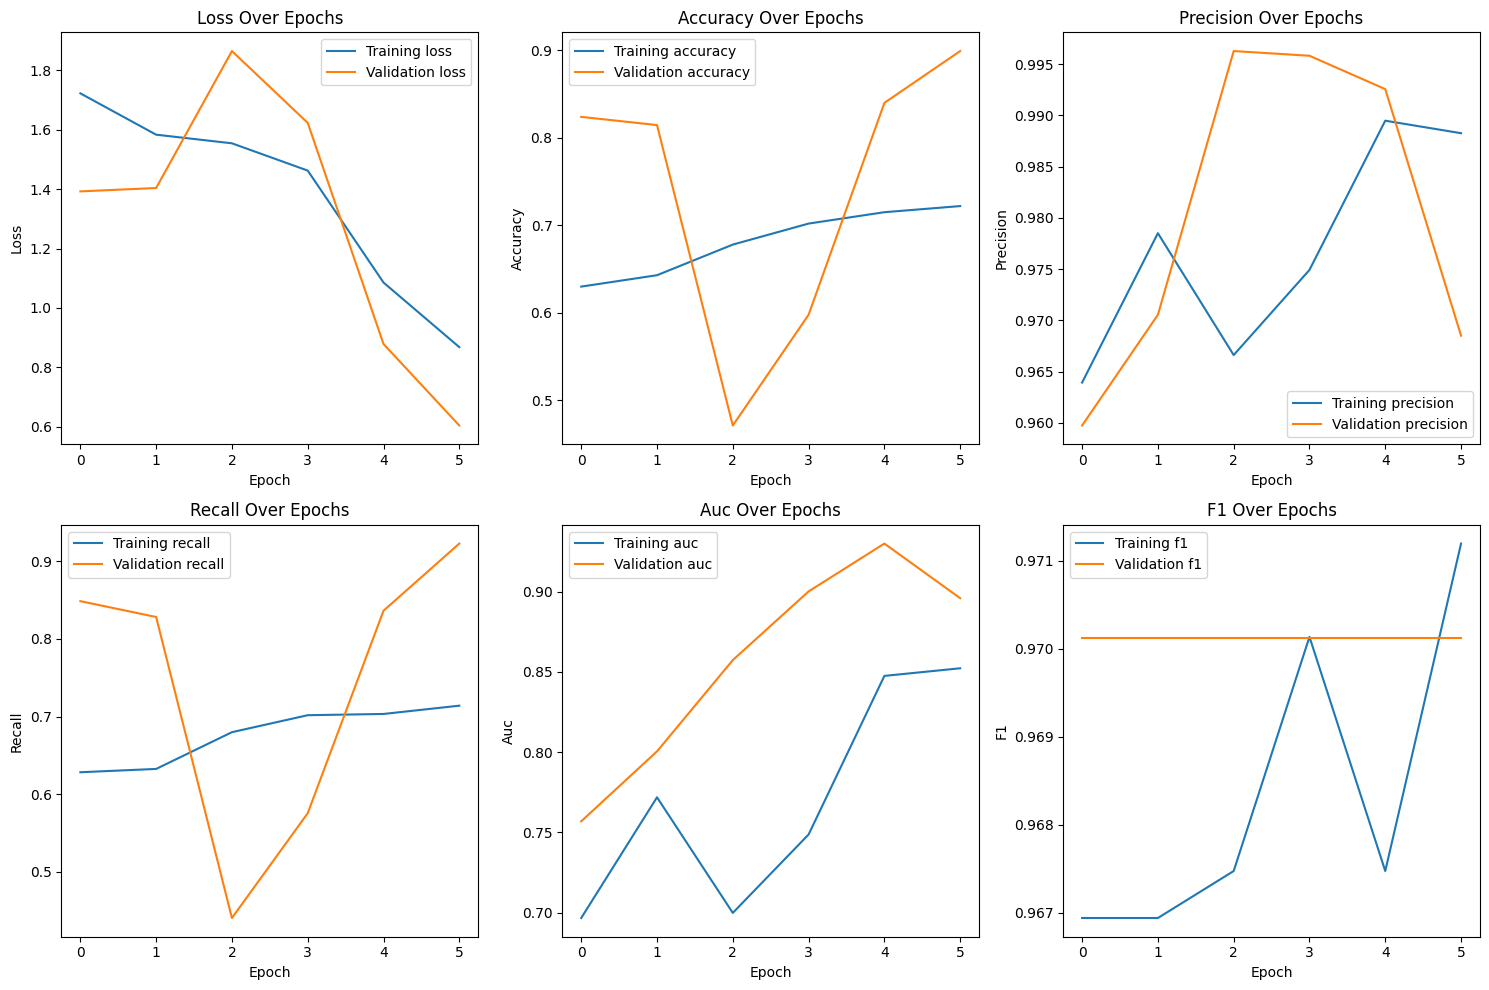

Generating predictions...


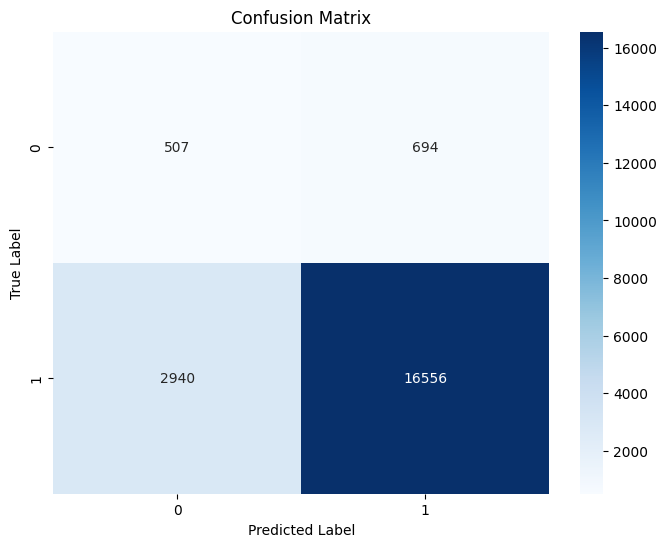


Classification Report:
              precision    recall  f1-score   support

         0.0       0.15      0.42      0.22      1201
         1.0       0.96      0.85      0.90     19496

    accuracy                           0.82     20697
   macro avg       0.55      0.64      0.56     20697
weighted avg       0.91      0.82      0.86     20697



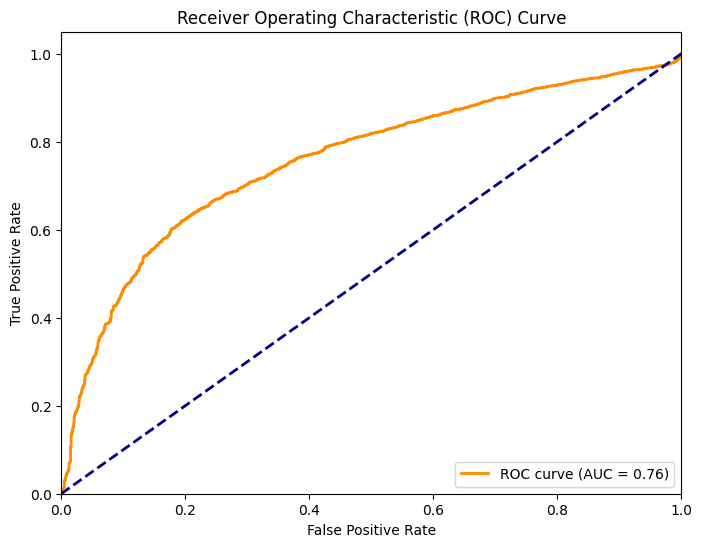

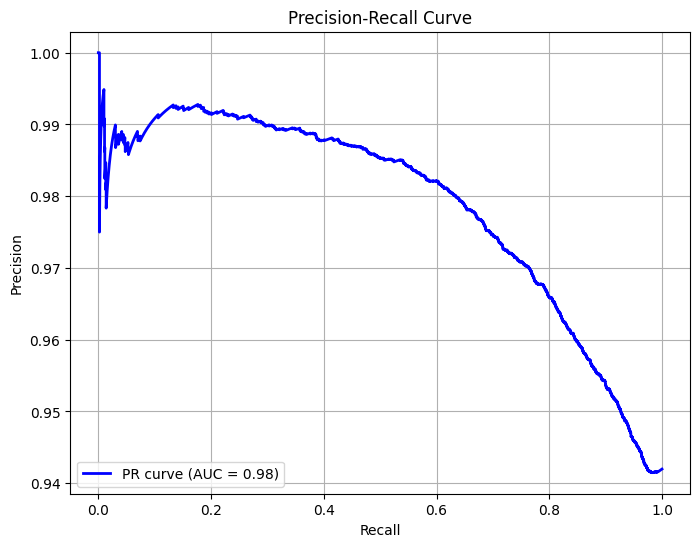


Final Metrics Summary:
ROC AUC: 0.7572
PR AUC: 0.9787

Per-class Metrics:
True Negatives: 507
False Positives: 694
False Negatives: 2940
True Positives: 16556

Sensitivity (Recall): 0.8492
Specificity: 0.4221
Precision: 0.9598
F1 Score: 0.9011

Evaluation results saved to 'evaluation_results.json'
Plots saved as PNG files


In [27]:
# 1. Load necessary libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve

# 2. Load the best saved model
best_model = tf.keras.models.load_model('best_model.h5')

# 3. Plot training history
def plot_training_history(history):
    metrics = ['loss', 'accuracy', 'precision', 'recall', 'auc', 'f1']
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for idx, metric in enumerate(metrics):
        axes[idx].plot(history.history[metric], label=f'Training {metric}')
        axes[idx].plot(history.history[f'val_{metric}'], label=f'Validation {metric}')
        axes[idx].set_title(f'{metric.capitalize()} Over Epochs')
        axes[idx].set_xlabel('Epoch')
        axes[idx].set_ylabel(metric.capitalize())
        axes[idx].legend()
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_training_history(history)

# 4. Generate predictions on test set
y_pred_proba = []
y_true = []
y_pred = []

print("Generating predictions...")
for images, labels in test_ds:
    predictions = best_model.predict(images, verbose=0)
    y_pred_proba.extend(predictions.flatten())
    y_true.extend(labels.numpy())
    y_pred.extend((predictions.flatten() > 0.5).astype(int))

y_pred_proba = np.array(y_pred_proba)
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 5. Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 6. Print classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# 7. Plot ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# 8. Plot Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

# 9. Print final metrics summary
print("\nFinal Metrics Summary:")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

# 10. Calculate and print per-class metrics
tn, fp, fn, tp = cm.ravel()
print("\nPer-class Metrics:")
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

# Calculate additional metrics
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
f1 = 2 * (precision * sensitivity) / (precision + sensitivity)

print(f"\nSensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

# 11. Save evaluation results
evaluation_results = {
    'confusion_matrix': cm.tolist(),
    'roc_auc': float(roc_auc),
    'pr_auc': float(pr_auc),
    'sensitivity': float(sensitivity),
    'specificity': float(specificity),
    'precision': float(precision),
    'f1_score': float(f1)
}

import json
with open('evaluation_results.json', 'w') as f:
    json.dump(evaluation_results, f, indent=4)

print("\nEvaluation results saved to 'evaluation_results.json'")

# 12. Optional: Save plots
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig('confusion_matrix.png')
plt.close()

# Save ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.close()

print("Plots saved as PNG files")

In [29]:
model.save('best_model.h5')

# 2. Convert the Model to TensorFlow Lite

In [25]:
import tensorflow as tf

model = tf.keras.models.load_model('best_model.h5')


In [28]:
import tensorflow as tf

# Load your trained model
# model = ... (your existing model)

def representative_dataset():
    # Use some training data samples
    for data in train_ds.take(100):
        yield [tf.cast(data[0], tf.float32)]

# Convert to TFLite with aggressive quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Enable all optimizations
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.representative_dataset = representative_dataset
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

# Force full integer quantization
converter.target_spec.supported_types = [tf.int8]
converter.experimental_new_quantizer = True

# Optional: Reduce model size further
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS_INT8,
    tf.lite.OpsSet.SELECT_TF_OPS
]

# Convert model
tflite_model = converter.convert()

# Save the quantized model
with open('model_int8.tflite', 'wb') as f:
    f.write(tflite_model)

# Print model size
print(f"Quantized model size: {len(tflite_model) / 1024 / 1024:.2f} MB")

INFO:tensorflow:Assets written to: /tmp/tmp4xt2yfdt/assets


INFO:tensorflow:Assets written to: /tmp/tmp4xt2yfdt/assets
/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2024-10-31 15:07:18.887900: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-10-31 15:07:18.887930: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-10-31 15:07:18.888098: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp4xt2yfdt
2024-10-31 15:07:18.891390: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-10-31 15:07:18.891403: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp4xt2yfdt
2024-10-31 15:07:18.899248: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-10-31 15:07:19.024964: I t

Quantized model size: 3.13 MB


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


In [27]:
# After training your model, add these conversion steps:

# 1. Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float32]  # or tf.uint8 for quantization

# Important: Set input shape explicitly
converter.target_spec.supported_ops = [
    tf.lite.OpsSet.TFLITE_BUILTINS,
    tf.lite.OpsSet.SELECT_TF_OPS
]

# Convert and save
tflite_model = converter.convert()

# Save the model
with open('model_int8.tflite', 'wb') as f:
    f.write(tflite_model)

# Verify the model
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Shape:", input_details[0]['shape'])  # Should show [1, 224, 224, 3]
print("Output Shape:", output_details[0]['shape'])

INFO:tensorflow:Assets written to: /tmp/tmp__6fn3ul/assets


INFO:tensorflow:Assets written to: /tmp/tmp__6fn3ul/assets


Input Shape: [  1 224 224   3]
Output Shape: [1 1]


2024-10-31 15:06:57.730931: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-10-31 15:06:57.730981: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-10-31 15:06:57.731145: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp__6fn3ul
2024-10-31 15:06:57.734754: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-10-31 15:06:57.734770: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp__6fn3ul
2024-10-31 15:06:57.744032: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-10-31 15:06:57.857668: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp__6fn3ul
2024-10-31 15:06:57.880116: I tensorflow/cc/saved_model/loader.cc:316] SavedModel load for tags { serve }; Status: success: OK. Took 148971 

In [34]:
def representative_dataset():
    for images, _ in train_ds.take(100):  # Adjust the number of batches to suit memory and calibration needs
        for image in images:
            yield [tf.expand_dims(image, axis=0)]

# Set up converter with representative dataset
converter.representative_dataset = representative_dataset
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

# Convert the model
tflite_model = converter.convert()


INFO:tensorflow:Assets written to: /tmp/tmprt5ngmxn/assets


INFO:tensorflow:Assets written to: /tmp/tmprt5ngmxn/assets
/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2024-10-30 12:19:05.427463: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-10-30 12:19:05.427489: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-10-30 12:19:05.427658: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmprt5ngmxn
2024-10-30 12:19:05.431567: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-10-30 12:19:05.431580: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmprt5ngmxn
2024-10-30 12:19:05.441895: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-10-30 12:19:05.557288: I t

In [33]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()


INFO:tensorflow:Assets written to: /tmp/tmpwlw1x40b/assets


INFO:tensorflow:Assets written to: /tmp/tmpwlw1x40b/assets
/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2024-10-30 12:17:34.630974: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-10-30 12:17:34.631001: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-10-30 12:17:34.631174: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpwlw1x40b
2024-10-30 12:17:34.634155: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-10-30 12:17:34.634167: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpwlw1x40b
2024-10-30 12:17:34.644356: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-10-30 12:17:34.766475: I t

NameError: name 'x_train' is not defined

In [35]:
with open('cifar10_model_quant.tflite', 'wb') as f:
    f.write(tflite_model)


In [36]:
def convert_to_c_array(filename):
    with open(filename, 'rb') as f:
        data = f.read()

    with open('model.h', 'w') as f:
        f.write('#ifndef MODEL_H_\n')
        f.write('#define MODEL_H_\n\n')
        f.write('const unsigned char cifar10_model_quant_tflite[] = {\n')

        for i, byte in enumerate(data):
            if i % 12 == 0:
                f.write('\n')
            f.write(f'0x{byte:02x}, ')

        f.write('\n};\n\n')
        f.write(f'const int cifar10_model_quant_tflite_len = {len(data)};\n')
        f.write('#endif  // MODEL_H_\n')

# Run the conversion function
convert_to_c_array('cifar10_model_quant.tflite')


In [37]:
import re

# Step 1: Read the binary data from cifar10_model_quant.tflite
with open('cifar10_model_quant.tflite', 'rb') as f:
    original_model_data = f.read()

# Step 2: Parse the C array from model.h
def parse_c_array(header_file):
    with open(header_file, 'r') as f:
        header_content = f.read()

    # Regular expression to match the hexadecimal values in the C array
    hex_values = re.findall(r'0x([0-9a-fA-F]{2})', header_content)
    model_data_from_header = bytes(int(hex_val, 16) for hex_val in hex_values)

    return model_data_from_header

# Get model data from model.h
model_data_from_header = parse_c_array('model.h')

# Step 3: Compare the two data arrays
if original_model_data == model_data_from_header:
    print("Success: The data in model.h matches the original .tflite model file.")
else:
    print("Error: The data in model.h does not match the original .tflite model file.")


Success: The data in model.h matches the original .tflite model file.


In [ ]:
#Objective: Convert the TensorFlow Lite model into a C array to include it in the ESP-IDF project.

And then put the following in the commandline: 

xxd -i cifar10_model_quant.tflite > model.h


In [14]:
import tensorflow as tf
import numpy as np

# 1. Load and parse the .h file
def parse_h_file(file_path):
    with open(file_path, 'r') as f:
        content = f.read()
    
    # Extract the byte array
    array_start = content.find('{') + 1
    array_end = content.find('};')
    byte_string = content[array_start:array_end]
    
    # Convert string of hex values to bytes
    bytes_array = bytes([int(x, 16) for x in byte_string.replace('\n', '').replace(' ', '').split(',') if x])
    return bytes_array

# 2. Load the model
model_bytes = parse_h_file('model.h')
interpreter = tf.lite.Interpreter(model_content=model_bytes)
interpreter.allocate_tensors()

# 3. Get and print model details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("\nModel Details:")
print("Input:", input_details)
print("Output:", output_details)

# 4. Test with random input
input_shape = input_details[0]['shape']
print(f"\nInput shape: {input_shape}")

# Create random test input
random_input = np.random.random(input_shape).astype(np.float32)
interpreter.set_tensor(input_details[0]['index'], random_input)

# Run inference
print("\nRunning inference with random input...")
interpreter.invoke()

# Get output
output = interpreter.get_tensor(output_details[0]['index'])
print(f"Output shape: {output.shape}")
print(f"Output values: {output}")

ValueError: `model_path` or `model_content` must be specified.

In [18]:
import tensorflow as tf
import numpy as np

# 1. Load and parse the .h file
def parse_h_file(file_path):
    with open(file_path, 'r') as f:
        content = f.read()
    
    # Extract the byte array
    array_start = content.find('{') + 1
    array_end = content.find('};')
    byte_string = content[array_start:array_end]
    
    # Convert string of hex values to bytes
    bytes_array = bytes([int(x, 16) for x in byte_string.replace('\n', '').replace(' ', '').split(',') if x])
    return bytes_array

# 2. Load the model
model_bytes = parse_h_file('/workspace/model.h')
interpreter = tf.lite.Interpreter(model_content=model_bytes)
interpreter.allocate_tensors()

# 3. Get and print model details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("\nModel Details:")
print("Input:", input_details)
print("Output:", output_details)

# 4. Test with random input
input_shape = input_details[0]['shape']
print(f"\nInput shape: {input_shape}")

# Create random test input
random_input = np.random.random(input_shape).astype(np.float32)
interpreter.set_tensor(input_details[0]['index'], random_input)

# Run inference
print("\nRunning inference with random input...")
interpreter.invoke()

# Get output
output = interpreter.get_tensor(output_details[0]['index'])
print(f"Output shape: {output.shape}")
print(f"Output values: {output}")

ValueError: `model_path` or `model_content` must be specified.